In [22]:
import numpy as np
import tifffile
from scipy import ndimage
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops


file_name = f"/Users/demir/Documents/Hva_AI/afstudeerproject/codes_yunus/input/tif_deneme_1.tif"

img = tifffile.imread(file_name)  # (Z, C, Y, X)
print(img.shape)

# Sadece 4. kanalı (C3, index 3) tüm Z-stack ile al
channel_index = 3
c3_stack = img[:, channel_index, :, :]  # Shape: (9, 1024, 1024)
c0_stack = img[:, 0, :, :]

print(c3_stack.shape)


(9, 4, 1024, 1024)
(9, 1024, 1024)


z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


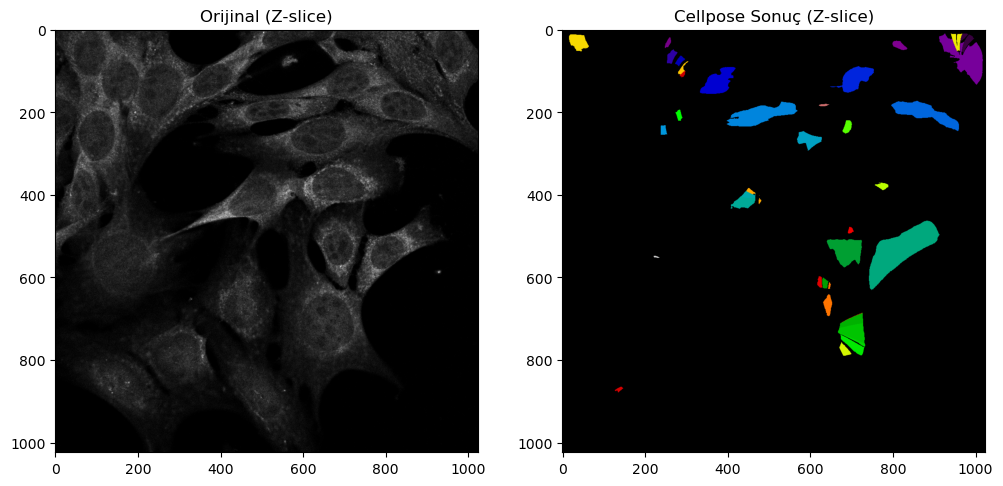

In [23]:
from cellpose import models, io
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# Cellpose modelini büyük hücreler için yükle
model = models.Cellpose(model_type='cyto')  # veya nuclei, ama büyük hücreler için cyto genellikle daha iyi

# Normalize ve filtrele
stack_normalized = (c3_stack - np.min(c3_stack)) / (np.max(c3_stack) - np.min(c3_stack))
stack_scaled = (stack_normalized * 255).astype(np.uint8)
stack_filtered = gaussian_filter(stack_scaled, sigma=2)  # Gürültü bastırılır

# Segmentasyon (manuel diameter ve yüksek min_size ile)
masks, flows, styles, diams = model.eval(
    stack_filtered,
    channels=[0, 0],
    do_3D=True,
    diameter=120,    # büyük hücreler için örnek çap değeri (gözle ölçüp ayarla)
    min_size=1500,   # küçük segmentleri eleyerek gereksiz maskeleri temizle
    stitch_threshold=0.4 # buyuk seyleri parcalamasin
)

# Görselleştirme
z_index = len(masks) // 2
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(stack_scaled[z_index], cmap='gray')
plt.title('Orijinal (Z-slice)')

plt.subplot(1, 2, 2)
plt.imshow(masks[z_index], cmap='nipy_spectral')
plt.title('Cellpose Sonuç (Z-slice)')
plt.show()

# Iteration 1
# diameter=80,    # büyük hücreler için örnek çap değeri (gözle ölçüp ayarla)
# min_size=1500,   # küçük segmentleri eleyerek gereksiz maskeleri temizle


In [24]:
# Maske sonuçlarını kaydet (.tif formatında)
output_mask_path = "/Users/demir/Documents/Hva_AI/afstudeerproject/codes_yunus/cellpose_mask_c3.tif"
tifffile.imwrite(output_mask_path, masks.astype(np.uint16))
print(f"Maskeler kaydedildi: {output_mask_path}")


Maskeler kaydedildi: /Users/demir/Documents/Hva_AI/afstudeerproject/codes_yunus/cellpose_mask_c3.tif


In [25]:
# 3D regionprops ile hücrelerin özelliklerini hesapla
labeled_mask = label(masks)  # skimage'in 3D label fonksiyonu

regions = regionprops(labeled_mask)

print(f"{len(regions)} hücre bulundu.\n")

# İlk 5 hücre için örnek bilgileri yazdır
for i, region in enumerate(regions[:5]):
    print(f"Hücre {i+1}:")
    print(f"- Hacim (voxel): {region.area}")
    print(f"- Centroid (Z, Y, X): {region.centroid}")
    print(f"- Bounding box: {region.bbox}")
    print()


60 hücre bulundu.

Hücre 1:
- Hacim (voxel): 4403.0
- Centroid (Z, Y, X): (3.9364069952305245, 27.521008403361346, 981.4739950034068)
- Bounding box: (0, 9, 963, 9, 59, 998)

Hücre 2:
- Hacim (voxel): 1657.0
- Centroid (Z, Y, X): (3.3258901629450817, 33.41219070609535, 256.56246228123115)
- Bounding box: (0, 20, 248, 9, 48, 265)

Hücre 3:
- Hacim (voxel): 3275.0
- Centroid (Z, Y, X): (4.789618320610687, 38.685496183206105, 813.7025954198473)
- Bounding box: (0, 28, 799, 9, 59, 837)

Hücre 4:
- Hacim (voxel): 48878.0
- Centroid (Z, Y, X): (5.209051106837432, 69.81793444903637, 977.1963460043373)
- Bounding box: (0, 8, 905, 9, 135, 1019)

Hücre 5:
- Hacim (voxel): 4152.0
- Centroid (Z, Y, X): (4.464354527938343, 65.35211946050096, 264.63439306358384)
- Bounding box: (0, 41, 254, 9, 90, 281)



In [27]:
from cellpose import models
from scipy.ndimage import gaussian_filter
import numpy as np

nuclei_stack = c0_stack  # 4x9x1024x1024 -> kanal 0
nuclei_norm = (nuclei_stack - nuclei_stack.min()) / (nuclei_stack.max() - nuclei_stack.min())
nuclei_filtered = gaussian_filter(nuclei_norm, sigma=1)
nuclei_uint8 = (nuclei_filtered * 255).astype(np.uint8)

model_nuclei = models.Cellpose(model_type='nuclei')
nuclei_masks, _, _, _ = model_nuclei.eval(
    nuclei_uint8,
    channels=[0, 0],
    do_3D=True,
    diameter=20,  # otomatik
    min_size=100
)

num_cells = len(np.unique(nuclei_masks)) - 1  # 0 arka plan


z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


KeyboardInterrupt: 